# Neural Networks for MNIST database #
Author: Marco Sousa
\
Last Updated Date: 3/7/2021
\
Details: This is an investigation of applying NN and C-NN onto the MNIST database, further investigating machine Learning for my DSC[499] Capstone assignment at UMass Dartmouth.

Much of the low level design was inspired by [Victor Zhou](https://victorzhou.com/about/) and his posts on [Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/). Many methods are mostly similar. If I have time, I'd like to return to this implementation to (1) generalize it and (2) change the matrix dimensions in relation to softmax (and its back propagation).

High level design using tensorflow/keras was learned via [TensorFlow](https://www.tensorflow.org/tutorials/keras/classification).

The primary text resource for machine learning and deep learning was by [Goodfellow et. al.](https://www.deeplearningbook.org/).

Below is a linked **Table of Contents:**

### Table of Contents ###

1. [MNIST Dataset](#one)
    1. Importing and Formatting
    2. Basic Visualization
2. [NN](#two)
3. [C-NN](#three)
    1. [Motivation for C-NN over NN for Images](#three-one)
    2. [C-NN Feedforward](#three-two)
        1. [Convolution](#three-two-one)
        2. [Maxpool](#three-two-two)
        3. [Softmax](#three-two-three)
        4. [Cross-Entropy Loss](#three-two-four)
        5. [Feedforward Method and Prediction](#three-two-five)
    3. [Back Propagation and Training](#three-three)
        1. [Softmax Back Propagation](#three-three-one)
        2. [Maxpool Back Propagation](#three-three-two)
        3. [Convolution Back Propagation](#three-three-three)
        4. [Training with Epochs](#three-three-four)
        5. [Keras Equivalent of Zhou Implementation](#three-three-five)
    4. [Official Keras CNN Example](#three-four)

### To Do Task List ###

- [x] Github Repo
- [x] K-Nearest Neighbor
- [ ] NN Low-Level
- [ ] NN by Keras/tensorflow
- [x] Code C-NN Low-Level
- [x] Convolution Class
- [x] Maxpool Class
- [x] Softmax Class
- [x] Cross Entropy Loss
- [x] Training C-NN
- [x] Make predictions for C-NN
- [x] C-NN by Keras/tensorflow (High-level)
- [ ] Consider changing the attribute dimensions for softmax and training
- [ ] Optional: Generalize Convolution Class out of 3x3
- [ ] Optional: Generalize  Maxpool Class out of 2x2
- [ ] Optional: Fickleness of input # of features for softmax
- [ ] Optional: I'd like to make a visualization as it passes feedforward/backprop

# MNIST Dataset <a class="anchor" id="one" name="one"></a> #


## Importing and Formatting##

In [1]:
#Importing libraries
import numpy as np 
import pandas as pd

#Machine Learning libraries
from tensorflow import keras
from tensorflow.keras import layers

#Visualization libraries
import matplotlib.pyplot as plt
#import altair as alt

#Counter dict class
from collections import Counter

In [3]:
#Importing MNIST data from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
#Converting to int32; forcing to 0-255 from uint8 causes error when subtraction leads to a negative value
xTrain = x_train.astype(np.int32)
yTrain = y_train.astype(np.int32)
xTest = x_test.astype(np.int32)
yTest = y_test.astype(np.int32)

## Basic Visualization ##

In [ ]:
#Printing shape
print('xTrain: ' + str(xTrain.shape))
print('yTrain: ' + str(yTrain.shape))
print('xTest: ' + str(xTest.shape))
print('yTest: ' + str(yTest.shape))

xTrain: (60000, 28, 28)
yTrain: (60000,)
xTest: (10000, 28, 28)
yTest: (10000,)


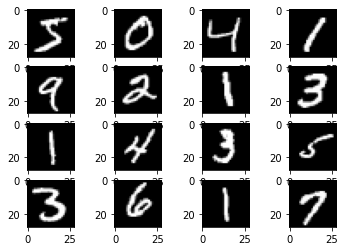

In [ ]:
#Visualizing the first 16 xTrain digits in a 4 by 4 grid.
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.imshow(xTrain[i-1], cmap=plt.get_cmap('gray'))

In [ ]:
#This of course reflects our yTrain labels on our 28x28 matrix of xTrain
yTrain[0:16]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7], dtype=int32)

We observe the label (or digit) distribution. It can be seen that both are mostly uniform. We could prove this with a Chi-Sqaured test, but the following is mostly convincing enough for now. 

In [ ]:
trainLabelDict = Counter(yTrain)
trainLabelDict

Counter({0: 5923,
         1: 6742,
         2: 5958,
         3: 6131,
         4: 5842,
         5: 5421,
         6: 5918,
         7: 6265,
         8: 5851,
         9: 5949})

<BarContainer object of 10 artists>

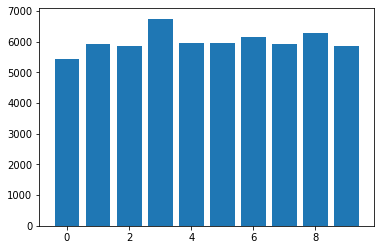

In [ ]:
plt.bar(range(len(trainLabelDict)), list(trainLabelDict.values()), align='center')

In [ ]:
testLabelDict = Counter(yTest)
testLabelDict

Counter({0: 980,
         1: 1135,
         2: 1032,
         3: 1010,
         4: 982,
         5: 892,
         6: 958,
         7: 1028,
         8: 974,
         9: 1009})

<BarContainer object of 10 artists>

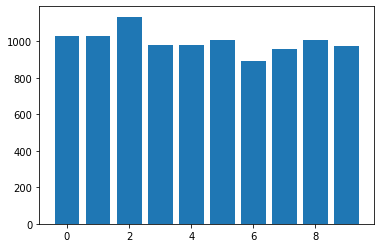

In [ ]:
plt.bar(range(len(testLabelDict)), list(testLabelDict.values()), align='center')

In [ ]:
#If we wish to view the raw matrix
#np.set_printoptions(edgeitems=1,linewidth=500,formatter=dict(float=lambda x: "%.3g" %x))
#xTrain[0]

# NN <a class="anchor" id="two" name="two"></a> #

# C-NN <a  class="anchor" id="three" name="three"></a> #


## Motivations for C-NN <a class="anchor" id="three-one" name="three-one"></a> ##

1. **Large Images:** Consider a larger image. 224x224 in size, with 3 RGB. Thus, we
have 224x224x3 features, or roughly 150,000 features. If we consider
many nodes, this is extraordinarily expensive
2. **Invariances:** Convolution better handles edge shifting, that is, if we slightly transform an image, it still retains its essential identification.

The following is a supervised method of C-NN training.

## C-NN Feedforward <a class="anchor" id="three-two" name="three-two"></a> ##



### Convolution <a class="anchor" id="three-two-one" name="three-two-one"></a> ###

In [ ]:
class Conv:
  #Convolutional Layer Class

  def __init__(self, dim, filterNum):
    #dim - length of one side of conv filter (e.g. 3x3, dim=3)
    #filterNum - determines how many convolution filter layers will be used
    #filters - numpy arr of filters initialized with random normal distribution values
    #Note: Dividing by 9 implements Xavier initialization

    self.dim = dim
    self.filterNum = filterNum
    self.filters = np.random.randn(filterNum, dim, dim) / 9

  def regionGenerator(self, image):
    """
    Input: An image of mxn
    Outpuut: 2d numpy arrays with yield
    Functionality: Generates all possible dimxdim image regions using valid padding.
    Note: Yield works better for the generator than returning a large list at once
    """
    m,n = image.shape

    for i in range(m - 2):
      for j in range(n - 2):
        region = image[i:(i + self.dim), j:(j + self.dim)]
        #Yielding (rather than returning) a location with dimxdim, with associated i,j
        yield region, i, j

  def forward(self,input):
    """
    Input: (image)
    Output:(convolution for each layerNumber convolution filter)
    Functionality: Performs a forward pass of a convolution layer
    """
    #shape of image
    m,n = input.shape
    #Blank output object of valid convolution for each filter
    output = np.zeros((m - 2, n - 2, self.filterNum))

    #We use our generator to iterate each region to perform the convolution
    #Each region has an i,j associated with it
    #np.sum takes the convolutoion for that region vs filters along axis=(1,2)
    for currentRegion,i,j in self.regionGenerator(input):
      output[i,j] = np.sum(currentRegion * self.filters, axis= (1,2))
    return output

Example of Convolution Layer

In [ ]:
object1 = Conv(3,8)
output = object1.forward(xTrain[0])
output.shape

(26, 26, 8)

Demonstration of Programming Used

Below it is demonstrated how the matrix multiplication and sum takes place appropirately

In [ ]:
#Here we can see filters are constructed appropriately
object2 = Conv(3,8)
object2.filters

array([[[ 0.1620258 , -0.03949712,  0.18592248],
        [-0.00688197, -0.13220466, -0.07185183],
        [ 0.05501568, -0.14325138, -0.05393859]],

       [[ 0.13471507,  0.17440606,  0.12440023],
        [ 0.13360631, -0.01311093,  0.07599943],
        [-0.22280663,  0.08263787,  0.17031129]],

       [[ 0.00961843, -0.08931186, -0.05837847],
        [ 0.02978031, -0.0013962 , -0.03631192],
        [-0.27779298,  0.13273665,  0.13168553]],

       [[ 0.01496955, -0.06553535, -0.0759538 ],
        [-0.02393561,  0.02524038,  0.15201885],
        [ 0.16809755,  0.03827875,  0.14757435]],

       [[-0.06009024, -0.09169747, -0.12797365],
        [-0.05763668, -0.133988  ,  0.00520959],
        [-0.07593835, -0.07040611,  0.02517824]],

       [[ 0.15254578, -0.04705088, -0.14702103],
        [ 0.00200645,  0.13341694, -0.09177518],
        [ 0.04109489, -0.02249475, -0.06718998]],

       [[-0.17804608, -0.07250985, -0.13954395],
        [ 0.03531423,  0.13210428,  0.04742926],
        

In [ ]:
#3x3 ones matrix
onesDemo = np.ones((3, 3))
onesDemo

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
#The following is ademonstration that multiplying a mxn matrix by an array of mxn matrices iterates each
#They retain the same values since element-wise and ones matrix
demonstration = onesDemo * object2.filters
demonstration

array([[[ 0.1620258 , -0.03949712,  0.18592248],
        [-0.00688197, -0.13220466, -0.07185183],
        [ 0.05501568, -0.14325138, -0.05393859]],

       [[ 0.13471507,  0.17440606,  0.12440023],
        [ 0.13360631, -0.01311093,  0.07599943],
        [-0.22280663,  0.08263787,  0.17031129]],

       [[ 0.00961843, -0.08931186, -0.05837847],
        [ 0.02978031, -0.0013962 , -0.03631192],
        [-0.27779298,  0.13273665,  0.13168553]],

       [[ 0.01496955, -0.06553535, -0.0759538 ],
        [-0.02393561,  0.02524038,  0.15201885],
        [ 0.16809755,  0.03827875,  0.14757435]],

       [[-0.06009024, -0.09169747, -0.12797365],
        [-0.05763668, -0.133988  ,  0.00520959],
        [-0.07593835, -0.07040611,  0.02517824]],

       [[ 0.15254578, -0.04705088, -0.14702103],
        [ 0.00200645,  0.13341694, -0.09177518],
        [ 0.04109489, -0.02249475, -0.06718998]],

       [[-0.17804608, -0.07250985, -0.13954395],
        [ 0.03531423,  0.13210428,  0.04742926],
        

In [ ]:
demo1 = np.sum(onesDemo * object1.filters, axis=(0)) #Sums each of the matrices...
demo2 = np.sum(onesDemo * object1.filters, axis=(1)) #Sums each col for each matrix
demo3 = np.sum(onesDemo * object1.filters, axis=(2)) #Sums each row for each matrix
demo4 = np.sum(onesDemo * object1.filters, axis=(1,2)) #Takes col and row sum for each matrix

#This may seem confusing, but it's actually really simple.
#We're asking for the max ACROSS the row and column axis, only, for each.
print(demo1)
print(demo2)
print(demo3) 
print(demo4) #Yes! A sum for each matrix 1x8

[[-0.48418365  0.22823476  0.20851229]
 [ 0.05070577 -0.38035465  0.41181257]
 [ 0.37919693 -0.24723711 -0.33250606]]
[[-0.20623554  0.09516286 -0.01933834]
 [-0.02108242 -0.13040184  0.22752261]
 [ 0.11757771 -0.37927459 -0.03802164]
 [ 0.10716064 -0.06063794  0.10955082]
 [-0.12847017 -0.09630738 -0.25285927]
 [-0.05512939  0.11672198 -0.06321427]
 [ 0.07913879  0.19505107  0.24843329]
 [ 0.05275943 -0.13967115  0.07574562]]
[[-0.05013998  0.11177847 -0.19204951]
 [-0.11005347  0.04345985  0.14263197]
 [-0.14087143 -0.22988503  0.07103793]
 [ 0.07677365  0.07825759  0.00104227]
 [ 0.05710694 -0.15913341 -0.37561035]
 [-0.12349455  0.15754881 -0.03567594]
 [ 0.20326116  0.21644847  0.10291352]
 [ 0.03998108 -0.13631106  0.08516388]]
[-0.13041102  0.07603835 -0.29971853  0.15607351 -0.47763682 -0.00162168
  0.52262315 -0.0111661 ]


### Maxpool Class <a class="anchor" id="three-two-two" name="three-two-two"></a> ###

Maxpool works nearly the same as convolution, except we take the max with no overlap instead.

Note that we use axis(0,1) here to sum the row and column but not 2 (which would be summing across the filters).

In [ ]:
class MaxPool:
  #Maxpool Class 
  #NOTE: We are restricted to a 2x2 maxpool for now
  def __init__(self, dim):
    #dim - length of one side of maxpool filter (e.g. 2x2, dim=2)
    #Note: Maxpool does not overlap regions like convolution class

    self.dim = dim

  def regionGenerator(self,image):
    m, n, _ = image.shape
    m2 = m // 2
    n2 = n // 2

    for i in range(m2):
      for j in range(n2):
        region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield region, i, j
          

  def forward(self, input):
    """
    Input: (matrix input)
    Output: 3d matrix array of dim(m/2,n/2,filterNum)
    Functionality: performs maxpool on input image for each filter
    """
      
    #Shape of matrix for each filter (filters make 3d)
    m, n, filterNum = input.shape
    #Empty output object for each filter
    output = np.zeros((m // 2, n // 2, filterNum))

    #Iterating across each region and finding max
    for region, i, j in self.regionGenerator(input):
      output[i, j] = np.amax(region, axis=(0, 1))
        
    return output

Example of MaxPool Layer

In [ ]:
conv = Conv(3,8)
pool = MaxPool(2)

In [ ]:
output = conv.forward(xTrain[0])
output = pool.forward(output)
output.shape

(13, 13, 8)

### Softmax Class <a class="anchor" id="three-two-three" name="three-two-three"></a> ###

Softmax converts a value distribution to a probability distribution. Taking the max of such will be the activation that allows for classification.

Softmax Formula:
 $$\frac{e^{x_i}}{\sum_{i=0}^{i=n} e^{x_i}} \text{ for } x_0...x_n$$




I considered modifying Zhou's method to fit a natural Ax=b form. However, the advantage of not doing this is that the weights and bias arrays are row arrays. This makes indexing straight forward, as we can avoid using column and row vectors, and instead stay with simple array indexing. Computationally these should be roughly the same, the only difference being that if we wish to preserve column vectors, we would need some additional indexing. My consideration was simply to use $(xA=b)^{T}$ = $A^Tx^T = b^T$.

For activation, we want to represent each of our features as a (weight*feature), weighting those features, compute a value corresponding to each digit 0...9, with some added bias. I will represent these as weights $\omega_{0...n}$ and bias $\beta_c$, for features $x_{0...n}$, for each digit class c.

Note that for n features, we actually index 0 to n-1, not n, in python. Also note that it is better to sum our bias after, rather than to matrix multiply, because then we can keep our bias separate as an attribute of the class (without concatonation or pre-allocation of matrix A).

Formula for c $\in$ {0,1,...,9}:
$$(\omega_0x_0)+(\omega_1x_1)+...+(\omega_nx_n) + \beta_c= d_c + \beta_c = \text{DigitValue}_{c}$$

Represented as a linear algebraic system of 10 equations:

Zhou's Method:
\begin{equation*}

\begin{bmatrix}
\omega_0  &\omega_0  & \cdots & \omega_n  
\end{bmatrix}

\begin{bmatrix} 
x_{0,0} & x_{0,1} & \cdots & x_{0,9} \\ 
x_{1,0} & x_{1,1} & \cdots & x_{1,9}\\
\vdots & \vdots & \ddots \\ 
x_{n,0} & x_{9,1} & & x_{n,9}
\end{bmatrix}
=
\begin{bmatrix}
d_0 + \beta_0  &d_1 +\beta_1  & \cdots & d_9+\beta_9 
\end{bmatrix}

\end{equation*}

Alternative Method:
\begin{equation*}

\begin{bmatrix} 
x_{0,0} & x_{0,1} & \cdots & x_{0,n} \\ 
x_{1,0} & x_{1,1} & \cdots & x_{1,n}\\
\vdots & \vdots & \ddots \\ 
x_{9,0} & x_{9,1} & & x_{9,n}
\end{bmatrix}

\begin{bmatrix}
\omega_0 \\ 
\omega_1 \\
\vdots \\ 
\omega_n 
\end{bmatrix}

=

\begin{bmatrix}
d_0  \\ 
d_1  \\
\vdots \\ 
d_9
\end{bmatrix}
+
\begin{bmatrix}
\beta_0 \\ 
\beta_1 \\
\vdots \\ 
\beta_9
\end{bmatrix}
=
\begin{bmatrix}
\vdots \\ 
t_c \\ 
\vdots
\end{bmatrix}

\end{equation*}
\
Ultimitely I settled on Zhou's method because the indexing is so natural, although the alternative is the more familiar to me.




In [ ]:

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, inputLen, nodes):
    # inputLen - number of features m*n*k along m,n,k dimensions
    # nodes - number of desired nodes
    # weights - 
    # Note: We divide by inputLen to reduce the variance of our initial values

    #np.random.seed(0)

    self.weights = np.random.randn(inputLen, nodes) / inputLen
    self.biases = np.zeros(nodes)

  def computeSoftmax(self, valArr):
    #Encapsulating the formal definition of softmax

    expArr = np.exp(valArr)
    return expArr / (np.sum(expArr, axis=0))

  def forward(self, input):
    """
    Input: Flattening allows for any input
    Output: 1d array of respective probability distribution
    Functionality: Computes fully connected softmax distribution with input array
    """
    #Flattens the input into 1d array
    input = input.flatten()

    #Calculating values for each class c
    totals = np.dot(input, self.weights) + self.biases

    #Computing and returning probability distribution
    return self.computeSoftmax(totals)

Example of Softmax Layer

In [ ]:
output = conv.forward(xTrain[0])
output = pool.forward(output)
softmax = Softmax(13 * 13 * 8, 10)
out = softmax.forward(output)
print(out)
print(np.sum(out))

[0.06330705 0.11898444 0.13886223 0.02231434 0.01060356 0.15252899
 0.09613176 0.19998856 0.14214247 0.0551366 ]
1.0


### Cross-Entropy Loss <a class="anchor" id="three-two-four" name="three-two-four"></a> ###

The cross-entropy loss function is commonly used for classification. Loss is calculated as a measure of he probability for a particular class c among a distribution (as was attained from the softmax function, for example).

Naturally, being a loss function, we want to minimize the loss error.

$$L = -\ln(p_c)$$

In [ ]:
def crossEntropyLoss(pc):
  """
  Input: pc, probability for label c
  Output: cross entropy loss
  Functionality: Calculates cross entropy loss
  """
  return (-np.log(pc))


In [ ]:
out[1]

0.1189844425733209

In [ ]:
crossEntropyLoss(out[1])

2.128762529095106

### Feedforward Method and Prediction <a class="anchor" id="three-two-five" name="three-two-five"></a> ###

Feedforward thus far

In [ ]:
conv = Conv(3,8)
pool = MaxPool(2)

In [ ]:
output = conv.forward(xTrain[0])
output = pool.forward(output)
softmax = Softmax(13 * 13 * 8, 10)
out = softmax.forward(output)
out

array([0.08599052, 0.08423136, 0.21316414, 0.04457939, 0.25236947,
       0.05047417, 0.02057091, 0.10155226, 0.11638111, 0.03068667])

Zhou implementation

We are interested in taking the test images and labels, and observing loss and accuracy for every 100. Noticibly, accuracy is roughly 10%, which is what we'd expect with a 1/10 chance of randomly guessing the correct digit. 

Once training occurs, we can start to see improvements as Gradient descents updates our weights as according to our partial derivative gradient.

In [ ]:
def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

print('MNIST CNN initialized!')

loss = 0
num_correct = 0
for i, (im, label) in enumerate(zip(xTest[0:400], yTest[0:400])):
  # Do a forward pass.
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

  # Print stats every 100 steps.
  if i % 100 == 99:
    print(
      '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
      (i + 1, loss / 100, num_correct)
    )
    loss = 0
    num_correct = 0




MNIST CNN initialized!
[Step 100] Past 100 steps: Average Loss 2.302 | Accuracy: 9%
[Step 200] Past 100 steps: Average Loss 2.302 | Accuracy: 13%
[Step 300] Past 100 steps: Average Loss 2.302 | Accuracy: 10%
[Step 400] Past 100 steps: Average Loss 2.303 | Accuracy: 8%


Alternative Identical Method

Object Instantiation and Feedforward Prep

In [ ]:
#Instantiation
conv = Conv(3,8)
pool = MaxPool(2)
softmax = Softmax(13 * 13 * 8, 10)

Alternative Feedforward

In [ ]:
def feedforwardModify(image,label):
  """
  Input: An image and label
  Output: probability distribution,loss,accuracy
  Functionality: Conducts forward pass predicting an image 
  """

  #converts to [-0.5,0.5]
  #feedforward through convolution,pool,activation,softmax
  output = conv.forward((image / 255) - 0.5)
  output = pool.forward(output)
  output = softmax.forward(output)

  loss = crossEntropyLoss(output[label])

  if(np.argmax(output) == label):
    acc = 1
  else:
    acc = 0

  return output, loss, acc


In [ ]:

print('MNIST CNN initialized!')
loss = 0
num_correct = 0
for i, (im, label) in enumerate(zip(xTest[0:400], yTest[0:400])):
  # Do a forward pass.
  _, l, acc = feedforwardModify(im, label)
  loss += l
  num_correct += acc

  # Print stats every 100 steps.
  if i % 100 == 99:
    print(
      '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
      (i + 1, loss / 100, num_correct)
    )
    loss = 0
    num_correct = 0

MNIST CNN initialized!
[Step 100] Past 100 steps: Average Loss 2.302 | Accuracy: 9%
[Step 200] Past 100 steps: Average Loss 2.302 | Accuracy: 13%
[Step 300] Past 100 steps: Average Loss 2.302 | Accuracy: 10%
[Step 400] Past 100 steps: Average Loss 2.303 | Accuracy: 8%


Feedforward without label in feedforward function

In [ ]:
def feedforward(image):
  """
  Input: An image
  Output: A probability distribution for a given test image
  Functionality: Conducts forward pass predicting an image
  """

  #converts to [-0.5,0.5]
  #feedforward through convolution,pool,activation,softmax
  output = conv.forward((image / 255) - 0.5)
  output = pool.forward(output)
  output = softmax.forward(output)

  return output


In [ ]:
feedforward(xTest[0])

array([0.10051936, 0.10015951, 0.09934844, 0.10009936, 0.10007277,
       0.09993042, 0.09971149, 0.10028407, 0.09955879, 0.10031578])

In [ ]:
# Loss and accuracy specific to the particular digit, rather than each 100

loss = np.zeros(len(xTest[0:500]))
predictedValues = np.zeros(len(xTest[0:500]))

for i, (im, label) in enumerate(zip(xTest[0:500], yTest[0:500])):

  #Feedforward a single image
  probDist = feedforward(xTest[i])

  #Predicted digit is the argmax of the prob distribution
  predictedDigit = np.argmax(probDist)

  #Storing loss for index i
  loss[i] = crossEntropyLoss(out[label])

  #Adding the digit into a prediction array for a confusion matrix
  predictedValues[i] = predictedDigit


In [ ]:
#Approximately the same overall mean loss
loss.mean()

2.5441826909785332

In [ ]:
from sklearn.metrics import confusion_matrix
confusionMat = confusion_matrix(yTest[0:500], predictedValues)
confusionMat

array([[ 0, 13,  0, 12,  6,  0,  2,  6,  0,  3],
       [ 3,  5,  0,  0,  9,  0,  0,  6,  0, 44],
       [ 2, 11,  0,  1,  4,  0,  0,  6,  0, 31],
       [ 2, 16,  0,  0, 11,  0,  1,  2,  0, 13],
       [ 2,  3,  0,  1, 21,  0,  0,  9,  0, 19],
       [ 2, 14,  0,  5, 16,  0,  0, 10,  0,  3],
       [ 0,  3,  0,  4, 17,  0,  0, 14,  0,  5],
       [14,  1,  0,  0,  8,  0,  0,  1,  0, 25],
       [ 0,  4,  0,  0, 12,  0,  0, 17,  0,  7],
       [ 2,  2,  0,  0, 22,  0,  0,  4,  0, 24]])

In [ ]:
#Also roughly 10%
confusionMat.trace() / np.sum(confusionMat)

0.102

## Back Propagation and Training <a class="anchor" id="three-three" name="three-three"></a>##

Now that we have a feedforward process, we need to be able to train our feedforward with back-propagation.

To do this, we will cache data for each layer. Then we will update our loss gradient as we pass through each layer, and as we update for each image.

Recall loss was defined using cross-entropy loss: $-\ln(p_c)$. As such, the derivative will be 

0 if i $\neq c$

$-\frac{1}{p_i}$ if i $=c$

There is quite some more calculus involved for calculating and updating the gradient. I will skip this for now, as Zhou covered it very well. Since it seems mostly definitional, I will copy his implementation, as far as I understand it.

In particular, we have a generalized gradient, but this general gradient has no way to be updated appropriately within our code. As such, we need to continue to derive until we can calculate gradients relative to what is in our code, namely weights, x pixel 'totals', and a bias for each class.

Thus, we calculate a entropy loss gradient. Then calculate a softmax gradient. Then from this we can find gradients in the former regards, and update those.

In [ ]:
#Overall Idea:

# Feed forward
#out = conv.forward((image / 255) - 0.5)
#out = pool.forward(out)
#out = softmax.forward(out)

# Calculate initial gradient
#gradient = np.zeros(10)
#gradient[label] = -1 / out[label]

# Backprop
#gradient = softmax.backprop(gradient)
#gradient = pool.backprop(gradient)
#gradient = conv.backprop(gradient)

In [ ]:
# Feed forward
out = conv.forward((xTest[0] / 255) - 0.5)
out = pool.forward(out)
out = softmax.forward(out)
out

array([0.10051936, 0.10015951, 0.09934844, 0.10009936, 0.10007277,
       0.09993042, 0.09971149, 0.10028407, 0.09955879, 0.10031578])

In [ ]:
label = np.argmax(out)
label

0

In [ ]:
#Thus we add the computed derivative at the location of the label, and 0 otherwise
gradient = np.zeros(10)
gradient[label] = -1 / out[label]
gradient

array([-9.94833281,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

### Softmax Back Propagation <a class="anchor" id="three-three-one" name="three-three-one"></a> ###

Zhou implementation:

In [ ]:
class Softmax:

  def __init__(self, inputLen, nodes):

    #Used for testing the method, but not used in practice
    np.random.seed(0)

    self.weights = np.random.randn(inputLen, nodes) / inputLen
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    #Simply used to test if indeed we arive at the same answer
    global d_out_d_t

    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input      
      d_t_d_b = 1      
      d_t_d_inputs = self.weights
      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t
      # Gradients of loss against weights/biases/input      
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]      
      d_L_d_b = d_L_d_t * d_t_d_b      
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases      
      self.weights -= learn_rate * d_L_d_w      
      self.biases -= learn_rate * d_L_d_b      
      return d_L_d_inputs.reshape(self.last_input_shape)


Testing out the Zhou implementation

In [ ]:
#Instantiation of conv and pool
conv = Conv(3,8)
pool = MaxPool(2)

In [ ]:
#Instantiation of softmax 
softmax = Softmax(13 * 13 * 8, 10)

In [ ]:
# Feedforward
out = conv.forward((xTest[0] / 255) - 0.5)
out = pool.forward(out)
out = softmax.forward(out)
out

array([0.09956664, 0.10051692, 0.09956403, 0.09976503, 0.0999775 ,
       0.09986324, 0.10034217, 0.10006443, 0.10011014, 0.10022991])

In [ ]:
label = np.argmax(out)

#Thus we add the computed derivative at the location of the label, and 0 otherwise
gradient = np.zeros(10)
gradient[label] = -1 / out[label]
gradient

array([ 0.        , -9.94857408,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
#Carrying out backpropagation
softmax.backprop(gradient)

In [ ]:
#Let's see if its the same with my implementation
d_out_d_t

array([-0.01000813,  0.09041327, -0.01000787, -0.01002807, -0.01004943,
       -0.01003795, -0.01008609, -0.01005817, -0.01006276, -0.0100748 ])

My implementation:

This implementation is mostly the same with some minor changes to how we find the nonzero, and some naming.

However, If I decide to change the dimensions of the prior implementation of softmax, to my matrix form, then I would edit this as well. Doing so would make the matrix multiplications of $\frac{d_L}{d_t} \cdot \frac{d_t}{d_{\text{wanted}}}$ more straightforward left multiplications, but result in column vectors when storing our attributes.

In [ ]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, inputLen, nodes):
    # inputLen - number of features m*n*k along m,n,k dimensions
    # nodes - number of desired nodes
    # weights - weights multiplied by x values
    # biases biases added to each tc = sum(xc*wc)
    # Note: We divide by inputLen to reduce the variance of our initial values

    #Used for testing the method, but not used in practice
    #np.random.seed(0)

    self.weights = np.random.randn(inputLen, nodes) / inputLen
    self.biases = np.zeros(nodes)

  def computeSoftmax(self, valArr):
    #Encapsulating the formal definition of softmax

    expArr = np.exp(valArr)
    return expArr / (np.sum(expArr, axis=0))

  def forward(self, input):
    """
    Input: Flattening allows for any input
    Output: 1d array of respective probability distribution
    Functionality: Computes fully connected softmax distribution with input array
    """

    # Stores original shape
    self.orginalShape = input.shape

    # Flattens the input into 1d array
    input = input.flatten()

    # Stores flat input
    self.flatInput = input

    # Calculating values for each class c
    totals = np.dot(input, self.weights) + self.biases

    # Stores activation sum of (weights*input)+bias_c
    self.flatTotals = totals

    # Computing and returning probability distribution
    return self.computeSoftmax(totals)

  def backprop(self, d_L_d_out,learn_rate):
    """
    Input: d_L_d_out; loss gradient at softmax
    Output: Updates loss gradient.
    Functionality: Backwards propagation for softmax layer
    """

    # Instead of for loop, extracting only nonzero
    i = np.nonzero(d_L_d_out)
    gradient = d_L_d_out[i]

    # Softmax calculations
    t_exp = np.exp(self.flatTotals)
    S = np.sum(t_exp)

    # Gradients of out[i] against totals
    d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
    d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

    # Gradients of loss against totals
    d_L_d_t = gradient * d_out_d_t
      
    # Gradients of totals against weights/biases/input
    d_t_d_w = self.flatInput      
    d_t_d_b = 1      
    d_t_d_inputs = self.weights

    # Gradients of loss against totals
    d_L_d_t = gradient * d_out_d_t

    # Gradients of loss against weights/biases/input 
    # These are what we are especially interested in    
    # Note: @ is simply the matmul function (matrix multiplication)
    # It took a bit of playing around to see that these indeed work
    #New axis simply increases dimension, so an np.array -> vector/matrix

    # Note that matrices are not commutative in multiplication
    # Note the pattern of chaining partial derivatives
    # Likewise, note dL/dt = dL/dout * dout/dt

    # dL/dw = dL/dout*dout/dt*dt/dw= dL/dt * dt/dw = dt/dw*dL/dt 
    d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]    

    # dL/db = dL/dt*dout/dt*dt/db = dL/dt*dt/db
    d_L_d_b = d_L_d_t * d_t_d_b    

    # dL/dinput = dL/dt*dout/dt*dt/dinput = dL/dt*dt/dinputs = dt/dinput * dL/dt
    d_L_d_inputs = d_t_d_inputs @ d_L_d_t

    # Update weights / biases with learn rate     
    self.weights -= learn_rate * d_L_d_w      
    self.biases -= learn_rate * d_L_d_b 

    return d_L_d_inputs.reshape(self.orginalShape)

In [ ]:
    #Hmmmm I might actually implement a new matrix schema...
    
    # Because of the shape...we'd have to take the transpose of the whole...
    #d_L_d_w2 = d_L_d_t[np.newaxis].T @ d_t_d_w[np.newaxis]
    #d_L_d_w2 = d_L_d_w2.T

Testing Our Back Propagation

In [ ]:
#Instantiation of softmax 
softmax = Softmax(13 * 13 * 8, 10)

In [ ]:
# Feedforward
out = conv.forward((xTest[0] / 255) - 0.5)
out = pool.forward(out)
out = softmax.forward(out)
out

array([0.09956664, 0.10051692, 0.09956403, 0.09976503, 0.0999775 ,
       0.09986324, 0.10034217, 0.10006443, 0.10011014, 0.10022991])

In [ ]:
label = np.argmax(out)

#Thus we add the computed derivative at the location of the label, and 0 otherwise
gradient = np.zeros(10)
gradient[label] = -1 / out[label]
gradient

array([ 0.        , -9.94857408,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
softmax.backprop(gradient)

In [ ]:
#Sugoi
d_out_d_t

array([-0.01000813,  0.09041327, -0.01000787, -0.01002807, -0.01004943,
       -0.01003795, -0.01008609, -0.01005817, -0.01006276, -0.0100748 ])

The following is personal testing for matrix dimensions

In [ ]:
#Instantiation of softmax 
softmax = Softmax(13 * 13 * 8, 10)

In [ ]:
# Feedforward
out = conv.forward((xTest[0] / 255) - 0.5)
out = pool.forward(out)
out = softmax.forward(out)
out

array([0.09956664, 0.10051692, 0.09956403, 0.09976503, 0.0999775 ,
       0.09986324, 0.10034217, 0.10006443, 0.10011014, 0.10022991])

In [ ]:
label = np.argmax(out)

#Thus we add the computed derivative at the location of the label, and 0 otherwise
gradient = np.zeros(10)
gradient[label] = -1 / out[label]
gradient

array([ 0.        , -9.94857408,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
nextOut1 = softmax.backprop(gradient,0.05)

In [ ]:
#Comparing my output with his...
nextOut == nextOut1

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

Training with only softmax back Propagation

In [ ]:
#Instantiation of softmax 
softmax = Softmax(13 * 13 * 8, 10)

In [ ]:
def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = feedforwardModify(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  # TODO: backprop MaxPool layer
  # TODO: backprop Conv layer

  return loss, acc

print('MNIST CNN initialized!')

# Train!
loss = 0
num_correct = 0
for i, (im, label) in enumerate(zip(xTrain[0:1000], yTrain[0:1000])):
  if i % 100 == 99:
    print(
      '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
      (i + 1, loss / 100, num_correct)
    )
    loss = 0
    num_correct = 0

  l, acc = train(im, label)
  loss += l
  num_correct += acc

MNIST CNN initialized!
[Step 100] Past 100 steps: Average Loss 2.246 | Accuracy: 22%
[Step 200] Past 100 steps: Average Loss 2.195 | Accuracy: 38%
[Step 300] Past 100 steps: Average Loss 2.116 | Accuracy: 56%
[Step 400] Past 100 steps: Average Loss 2.031 | Accuracy: 69%
[Step 500] Past 100 steps: Average Loss 1.977 | Accuracy: 67%
[Step 600] Past 100 steps: Average Loss 1.987 | Accuracy: 50%
[Step 700] Past 100 steps: Average Loss 1.936 | Accuracy: 53%
[Step 800] Past 100 steps: Average Loss 1.844 | Accuracy: 71%
[Step 900] Past 100 steps: Average Loss 1.785 | Accuracy: 74%
[Step 1000] Past 100 steps: Average Loss 1.755 | Accuracy: 70%


### Maxpool Back Propagation <a class="anchor" id="three-three-two" name="three-three-two"></a> ###

In [ ]:
class MaxPool:
  #Maxpool Class 
  #NOTE: We are restricted to a 2x2 maxpool for now
  def __init__(self, dim):
    #dim - length of one side of maxpool filter (e.g. 2x2, dim=2)
    #Note: Maxpool does not overlap regions like convolution class

    self.dim = dim

  def regionGenerator(self,image):
    m, n, _ = image.shape
    m2 = m // 2
    n2 = n // 2

    for i in range(m2):
      for j in range(n2):
        region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield region, i, j
          

  def forward(self, input):
    """
    Input: (matrix input)
    Output: 3d matrix array of dim(m/2,n/2,filterNum)
    Functionality: performs maxpool on input image for each filter
    """

    self.last_input = input

    #Shape of matrix for each filter (filters make 3d)
    m, n, filterNum = input.shape
    #Empty output object for each filter
    output = np.zeros((m // 2, n // 2, filterNum))

    #Iterating across each region and finding max
    for region, i, j in self.regionGenerator(input):
      output[i, j] = np.amax(region, axis=(0, 1))
        
    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for region, i, j in self.regionGenerator(self.last_input):
      h, w, f = region.shape
      amax = np.amax(region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input



### Convolution Back Propagation <a class="anchor" id="three-three-three" name="three-three-three"></a> ###

In [ ]:
class Conv:
  #Convolutional Layer Class

  def __init__(self, dim, filterNum):
    #dim - length of one side of conv filter (e.g. 3x3, dim=3)
    #filterNum - determines how many convolution filter layers will be used
    #filters - numpy arr of filters initialized with random normal distribution values
    #Note: Dividing by 9 implements Xavier initialization

    self.dim = dim
    self.filterNum = filterNum
    self.filters = np.random.randn(filterNum, dim, dim) / 9

  def regionGenerator(self, image):
    """
    Input: An image of mxn
    Outpuut: 2d numpy arrays with yield
    Functionality: Generates all possible dimxdim image regions using valid padding.
    Note: Yield works better for the generator than returning a large list at once
    """
    m,n = image.shape

    for i in range(m - 2):
      for j in range(n - 2):
        region = image[i:(i + self.dim), j:(j + self.dim)]
        #Yielding (rather than returning) a location with dimxdim, with associated i,j
        yield region, i, j

  def forward(self,input):
    """
    Input: (image)
    Output:(convolution for each layerNumber convolution filter)
    Functionality: Performs a forward pass of a convolution layer
    """
    #shape of image
    m,n = input.shape
    #Blank output object of valid convolution for each filter
    output = np.zeros((m - 2, n - 2, self.filterNum))

    #Cache input
    self.last_input = input

    #We use our generator to iterate each region to perform the convolution
    #Each region has an i,j associated with it
    #np.sum takes the convolutoion for that region vs filters along axis=(1,2)
    for currentRegion,i,j in self.regionGenerator(input):
      output[i,j] = np.sum(currentRegion * self.filters, axis= (1,2))
    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for region, i, j in self.regionGenerator(self.last_input):
      for f in range(self.filterNum):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    #Not returning anything here since we use Conv as the first layer
    #Otherwise, return the loss gradient for this layer inputs like other layers
    return None


### Training with Epochs <a class="anchor" id="three-three-four" name="three-three-four"></a> ### 

In [ ]:
#Instantiation of conv and pool
conv = Conv(3,8)
pool = MaxPool(2)
softmax = Softmax(13 * 13 * 8, 10)

In [ ]:
def feedforwardModify(image,label):
  """
  Input: An image and label
  Output: probability distribution,loss,accuracy
  Functionality: Conducts forward pass predicting an image 
  """

  #converts to [-0.5,0.5]
  #feedforward through convolution,pool,activation,softmax
  output = conv.forward((image / 255) - 0.5)
  output = pool.forward(output)
  output = softmax.forward(output)

  loss = crossEntropyLoss(output[label])

  if(np.argmax(output) == label):
    acc = 1
  else:
    acc = 0

  return output, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = feedforwardModify(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

In [ ]:
train_images = xTrain[:1000]
train_labels = yTrain[:1000]
test_images = xTest[:1000]
test_labels = yTest[:1000]

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i > 0 and i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.215 | Accuracy: 19%
[Step 200] Past 100 steps: Average Loss 1.966 | Accuracy: 33%
[Step 300] Past 100 steps: Average Loss 1.459 | Accuracy: 64%
[Step 400] Past 100 steps: Average Loss 1.087 | Accuracy: 65%
[Step 500] Past 100 steps: Average Loss 0.862 | Accuracy: 75%
[Step 600] Past 100 steps: Average Loss 0.914 | Accuracy: 72%
[Step 700] Past 100 steps: Average Loss 0.688 | Accuracy: 81%
[Step 800] Past 100 steps: Average Loss 0.684 | Accuracy: 77%
[Step 900] Past 100 steps: Average Loss 0.745 | Accuracy: 77%
[Step 1000] Past 100 steps: Average Loss 0.594 | Accuracy: 83%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.429 | Accuracy: 89%
[Step 200] Past 100 steps: Average Loss 0.461 | Accuracy: 85%
[Step 300] Past 100 steps: Average Loss 0.582 | Accuracy: 85%
[Step 400] Past 100 steps: Average Loss 0.672 | Accuracy: 78%
[Step 500] Past 100 steps: Average Loss 0.630 | Accuracy: 80%
[Step 600] Pas

Observations

Following along with Zhou, and working with his implementation has gave me a very solid grasp on these introductory components! This was very exciting.

Some things I'd consider coming back to change (not in a particular order):

1. Generalize our methods:
\
For example, Conv3x3 or Conv5x5 for dim = 3 or 5
\
Or perhaps a different maxpooling number
2. Modify the matrix multiplication of Softmax and the attributes to be column (IF AND ONLY IF such implementation is not much more computationally taxxing)
3. Cleaner and better encapsulation for the training and testing
4. Completely train, then completely test. Confusion Matrix too

### Keras Equivalent of Zhou Implementation <a class="anchor" id="three-three-five" name="three-three-five"></a> ###

Please note this was done by Zhou himself, and I am simply copying it here. After implementing C-NN from the ground up, he then proceeds to make the same implementation using keras, as is found in his  [keras cnn tutorial](https://victorzhou.com/blog/keras-cnn-tutorial/). 




In [ ]:
#Importing keras utilities
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [ ]:
# Normalize the images.
xTrain2 = (xTrain / 255) - 0.5
xTest2 = (xTest / 255) - 0.5

# Reshape the images.
xTrain2 = np.expand_dims(xTrain2, axis=3)
xTest2 = np.expand_dims(xTest2, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  xTrain2,
  to_categorical(yTrain),
  epochs=3,
  validation_data=(xTest2, to_categorical(yTest)),
)

# Save the model to disk.
model.save_weights('cnn.h5')

# Load the model from disk later using:
# model.load_weights('cnn.h5')

# Predict on the first 5 test images.
predictions = model.predict(xTest2[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]

Epoch 1/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.5563 - accuracy: 0.8424 - val_loss: 0.1836 - val_accuracy: 0.9482
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1844 - accuracy: 0.9476 - val_loss: 0.1357 - val_accuracy: 0.9592
Epoch 3/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1271 - accuracy: 0.9636 - val_loss: 0.1042 - val_accuracy: 0.9682
[7 2 1 0 4]
[7 2 1 0 4]


Awesome! So we implemented CNN from the ground up using numpy, and also using keras, working to an accuracy of roughly 96 to 97 percent. 

What if we consider more questions regarding our C-NN architecture:

We should consider playing around with other conv, maxpool, and softmax sizes/layers, and what if we include more/less layers? 

What else can we add to the model? What about dropout layers? Fully connected, or no?

Lots of questions!

## Official Keras CNN Example <a class="anchor" id="three-four" name="three-four"></a> ##

The [keras documentation](https://keras.io/getting_started/) provides a 99% accurate [example of CNN](https://keras.io/examples/vision/mnist_convnet/) for the MNIST database.

The example features mostly the same architecture as prior but with some modification:
1. There are two convolutional layers
2. Convolutional layers have 32 and 64 filters of (same) size 3x3
2. A dropout layer is introduced
4. 15 epochs instead of 3
5. Batch normalization

These seem like fairly reasonable additions to our architecture. 

My primary question is "why" this architecture. What inferences about our data lead us to say $k_1$ filters is better than $k_2$ filters? What kind of inferences can we make prior to model construction to give us insight onto the appropriate number of filters, layers, and so forth, regarding neural networks?

In [23]:
#Importing
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
#Importing MNIST data from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [25]:
#Converting to int32; forcing to 0-255 from uint8 causes error when subtraction leads to a negative value
xTrain = x_train.astype(np.int32)
yTrain = y_train.astype(np.int32)
xTest = x_test.astype(np.int32)
yTest = y_test.astype(np.int32)

In [26]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

In [27]:
#Preprocessing the data

# Scale images to the [0, 1] range
xTrain = xTrain.astype("float32") / 255
xTest = xTest.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
xTrain = np.expand_dims(xTrain, -1)
xTest = np.expand_dims(xTest, -1)

# convert class vectors to binary class matrices
yTrain = keras.utils.to_categorical(yTrain, num_classes)
yTest = keras.utils.to_categorical(yTest, num_classes)

In [28]:
xTrain.shape

(60000, 28, 28, 1)

In [29]:
#building the model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [30]:
#Defining batch size and number of epochs
batch_size = 128
epochs = 15

#compile the model with corss entorpy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#Fit the model with batch normalization and validation splitting
model.fit(xTrain, yTrain, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 40s 93ms/step - loss: 0.7473 - accuracy: 0.7690 - val_loss: 0.0717 - val_accuracy: 0.9800
Epoch 2/15
422/422 [==============================] - 39s 93ms/step - loss: 0.1178 - accuracy: 0.9637 - val_loss: 0.0539 - val_accuracy: 0.9848
Epoch 3/15
422/422 [==============================] - 39s 93ms/step - loss: 0.0861 - accuracy: 0.9726 - val_loss: 0.0461 - val_accuracy: 0.9875
Epoch 4/15
422/422 [==============================] - 40s 94ms/step - loss: 0.0710 - accuracy: 0.9782 - val_loss: 0.0416 - val_accuracy: 0.9898
Epoch 5/15
422/422 [==============================] - 40s 94ms/step - loss: 0.0601 - accuracy: 0.9815 - val_loss: 0.0363 - val_accuracy: 0.9902
Epoch 6/15
422/422 [==============================] - 40s 94ms/step - loss: 0.0545 - accuracy: 0.9834 - val_loss: 0.0376 - val_accuracy: 0.9880
Epoch 7/15
422/422 [==============================] - 40s 94ms/step - loss: 0.0515 - accuracy: 0.9844 - val_loss: 0.0344 - val_accuracy:

In [31]:
#Evaluating the model against test data
score = model.evaluate(xTest, yTest, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02281571738421917
Test accuracy: 0.9927999973297119
